<a href="https://colab.research.google.com/github/ANANTHMANOJ/phenmonia_eda/blob/master/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pneumonia

Pneumonia is one among the list of top-10 causes of death in some countries. Initally it requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR.

## Chest X-RAY basics and What Opacity Means

In the process of taking the image, an [X-ray](https://en.wikipedia.org/wiki/X-ray) passes through the body and reaches a detector on the other side. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb the X-rays and appear white in the image.
In short - 
* Black = Air 
* White = Bone 
* Grey = Tissue or Fluid

The left side of the subject is on the right side of the screen by convention. You can also see the small L at the top of the right corner. 
In a normal image we see the lungs as black, but they have different projections on them - mainly the rib cage bones, main airways, blood vessels and the heart.

Any area in the chest radiograph that is more white than it should be can term as ***Opacity*** 

Usually the lungs are full of air. When someone has pneumonia, the air in the lungs is replaced by other material - fluids, bacteria, immune system cells, etc. That's why areas of opacities are areas that are grey but should be more black. When we see them we understand that the lung tissue in that area is probably not healthy.

So in short, 


*   Balck Area in lungs  --> Healthy
*   white / Grey in the lungs  --> Unhealthy or Have Opacity

## Problem Faced

There are some problems that are faced in hospitals. Some of them are jotted bellow:
* Identifing the pneumonia needs specialized and trained doctors, as to find the minute spots in X-Rays and other symtoms.
* And  examining the X-Rays would take time for any such doctors.
* Lack of Specialized doctors in remote places of the world makes it difficult to identify such diseases.

So, how can we over come this problem will be over concern, which drives to our project identification of Pneumonia.

##  Objective

### Our objective is to build a model which takes a CXR image as input and attempts to find potentially infected-area and predicts the position of box/boxes bounding the infected area.

#### How would this project  worthy?

* Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. 
* Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology).
* Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

#### Plans to achieve the objective

- We have understood our goal to achieve, i.e to build a pneumonia detection system, to locate the position of inflammation in an image.
- The dataset has been collected to explore the various scenarios of pneumonia cases in patient.
- Exploring the data, feature extracting the data required and preparing the data for the model.
- Identifing the suitable model for our problem, finding the accuracy of the model and fine tuning the model to give best results.

It is a supervised-learning problem

## About Data

#### Description of the Pneumonia Dataset

Data consists of following files :
1.   stage_2_train_images
2.   stage_2_test_images
3.   stage_2_detailed_class_info.csv - contains information about the positive and negative classes in the training set
4.   stage_2_train_labels.csv - contains information about bounding boxes along with train dataset images

The training data is provided as a set of patientIds and bounding boxes. Bounding boxes are defined as follows: `x-min y-min width height`

There is also a binary target column, `Target`, indicating pneumonic or non-pneumonic.

There may be multiple rows per `patientId`.

In [ ]:
import tensorflow as tf      # for building the model
import pandas as pd          # for reading the csv files
import numpy as np           # for basic mathematic functions
import pydicom as dicom      # to read the.dcm files
import os
import cv2
from pathlib import Path

 # for visualization proecess
import matplotlib.pyplot as plt     
from matplotlib.patches import Rectangle
import seaborn as sns

 # for saving and loading the model
import pickle
import cv2 as cv
from concurrent.futures import ProcessPoolExecutor
import csv
import random
import keras
import pydicom
import shutil

# for defining the layers of the model
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as kera
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
# path of data folder
data_path = Path('rsna-pneumonia-detection-challenge')

## Class info

In [ ]:
class_info_path = data_path / 'stage_2_detailed_class_info.csv'

In [ ]:
class_info = pd.read_csv(class_info_path)

In [ ]:
class_info.shape

(30227, 2)

- Total 30227 records

In [ ]:
class_info.head(2)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal

In [ ]:
# Total patients
class_info['patientId'].nunique()

26684

- Total patients - 26684

### A patient may fall into any of the 3 categories:
#### label-1
- having Pneumonia, 

##### label-0
- not having Pneumonia and normal
- not having Pneumonia and not-normal/no-lung-opacity

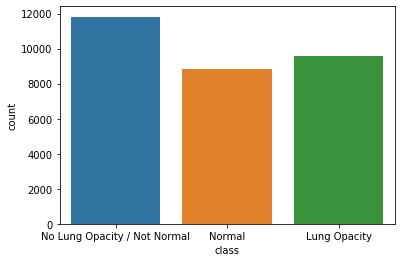

In [ ]:
sns.countplot(class_info['class']);

- Not Normal ~ 12000 
- Normal ~ 9000
- Lung Opacity ~ 9500

- Class ditribution is imbalanced - having more records in  class-0 (non-pneumonia) than class-1 (pneumonia)

## Labels data

In [ ]:
labels_path = data_path / 'stage_2_train_labels.csv'

In [ ]:
labels = pd.read_csv(labels_path)

In [ ]:
labels.shape

(30227, 6)

- Total records = 30227

In [ ]:
labels.head(2)

patientId   x   y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0

- Total 6 columns
- 1 for id
- 4 for position of box
- 1 for Target variable

In [ ]:
labels['patientId'].nunique()

26684

- Total patients = 26684
- A patient may have multiple records corresponding to each infected area.

In [ ]:
n_infected_area = labels.groupby('patientId').sum()['Target']

#### Number of Healthy patients

In [ ]:
(n_infected_area==0).sum()

20672

#### Number of infected patients

In [ ]:
(n_infected_area!=0).sum()

6012

In [ ]:
'Infected Patients - {0:.1f} %'.format(6012/20672*100)

'Infected Patients - 29.1 %'

#### Class distribution

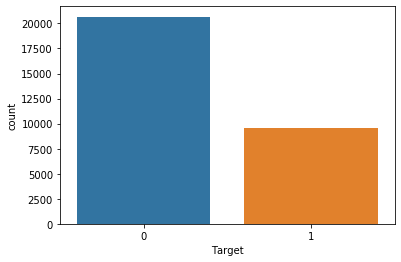

In [ ]:
sns.countplot(labels['Target']);

In [ ]:
np.bincount(labels['Target'])

array([20672,  9555])

- class-0 (not infected) -- 20672
- class-1 (infected)     -- 9555

#### Here, no. of infected patients is 6012 while number of records in class-1 is 9555, the difference is because  a patient may have more than 1 infected area and thus having more than 1 record per patient 

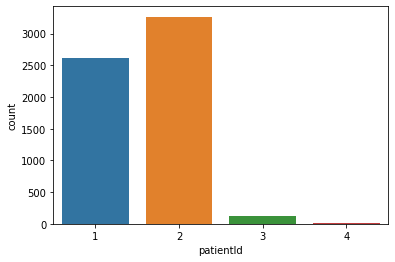

In [ ]:
# this plot depicts the distribution of number-of-infected-area among infected patients.
sns.countplot(labels[labels['Target']==1]['patientId'].value_counts());

- Almost all people have 1 or 2 infected areas
- Very few people with 3 or 4 infected areas

Scatter plot for the center of the bounding-box points in the plane x0y.   The centers of the rectangles are the points $$x_c = x + \frac{width}{2}$$ and $$y_c = y + \frac{height}{2}$$

We will show a sample of center points superposed with the corresponding sample of the rectangles.
The rectangles are created using the method described in Kevin's Kernel <a href="#4">[1]</a>


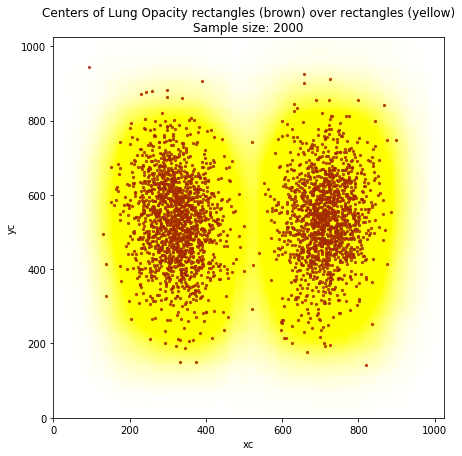

In [ ]:
target1 = labels[labels['Target']==1]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
target_sample = target1.sample(3000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title('Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000')
target_sample.plot.scatter(x='xc', y='yc', xlim=(0, 1024), ylim=(0, 1024), ax=ax, alpha=0.8, marker=".", color='brown')
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

##### For class-0 there are obviously no box coordinates as they are non-pneumonic so all must be nan

In [ ]:
labels[labels['Target'] == 0].isna().all()

patientId    False
x             True
y             True
width         True
height        True
Target       False
dtype: bool

###### For class-1 let's check for any nan values

In [ ]:
labels[labels['Target'] == 1].isna().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

The `labels` and `class_info` datasets do not share a joining keyword column, but the rows are listed in the exact same order, therefore we can combine the two dataframes by concatenating their columns.

## Distribution of position of bounding-box

In [ ]:
# df --> all positive records
df = labels[labels['Target'] == 1]
df.head(2)

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

#### 1. Scatter plot

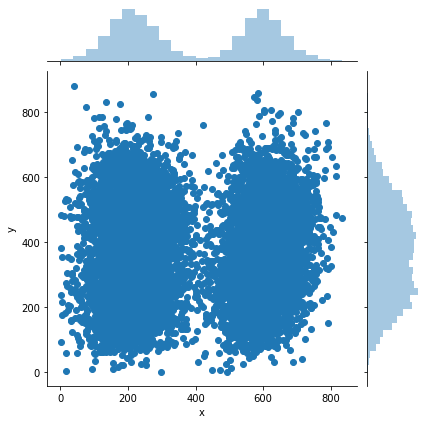

In [ ]:
sns.jointplot(x = 'x', y = 'y', data = df, kind = 'scatter');

#### 2. Box plot

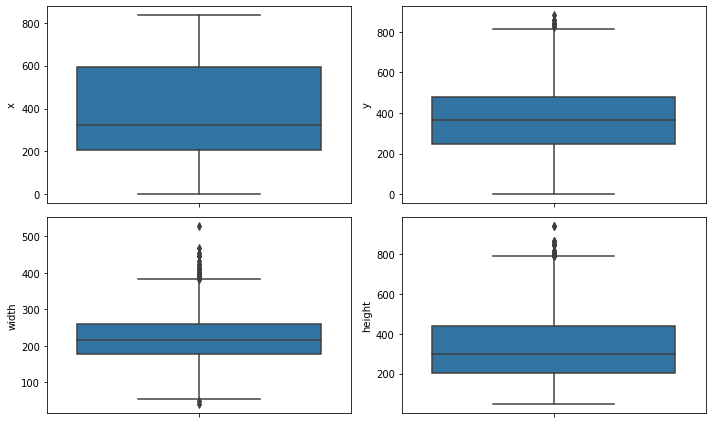

In [ ]:
n_columns = 2
n_rows = 2
_, axes = plt.subplots(n_rows, n_columns, figsize=(5 * n_columns, 3 * n_rows))
for i, c in enumerate(df.columns[1:-1]):
    sns.boxplot(y = c, data = df, ax = axes[i // n_columns, i % n_columns])
plt.tight_layout()
plt.show()

## Image data

In [ ]:
images_path = data_path / 'stage_2_train_images'

In [ ]:
# Total number of patients
n_patient = len(os.listdir(images_path))
n_patient

26684

In [ ]:
filename = os.listdir(images_path)[0]

file = dicom.dcmread(images_path / filename)

In [ ]:
file.pixel_array.shape

(1024, 1024)

- Given CXR is 1024x1024 dimensional 2-D image. We might perhaps need to reshape the data appropriately.

In [ ]:
file.dir()

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition']

### Above are the attributes of which only a handful are available to us, namely, PatientAge, PatientSex, ViewPosition

In [ ]:
def get_attrib(filename):
    '''Returns: tuple, containing age and gender corresponding to filename'''
    id = filename.split('.')[0]
    file = dicom.dcmread(images_path / filename)
    return (id, file.PatientAge, file.PatientSex, file.ViewPosition)

In [ ]:
# Using python built-in Multi-Processing API to load age and gender
with ProcessPoolExecutor() as executor:
    a = list(executor.map(get_attrib, os.listdir(images_path)))

In [ ]:
attrib = pd.DataFrame(a, columns=['id', 'age', 'gender', 'view-position'])

In [ ]:
attrib.head(3)

id age gender view-position
0  bec78094-d857-42e0-b4fb-c6a67ec1da8e  50      F            PA
1  9bfe74ff-3d81-45eb-ad67-18dc30f6d48a  31      M            PA
2  ce13294e-e01d-4074-86dc-0dd747226a5c  52      M            AP

In [ ]:
attrib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26684 non-null  object
 1   age            26684 non-null  object
 2   gender         26684 non-null  object
 3   view-position  26684 non-null  object
dtypes: object(4)
memory usage: 834.0+ KB


##### age

In [ ]:
attrib['age'] = attrib['age'].astype('int8')

In [ ]:
attrib.describe().T

count       mean        std    min   25%   50%   75%   max
age  26684.0  46.982049  16.877806 -108.0  34.0  49.0  59.0  92.0

In [ ]:
(attrib['age']<0).sum()

5

- 5 negative

##### gender

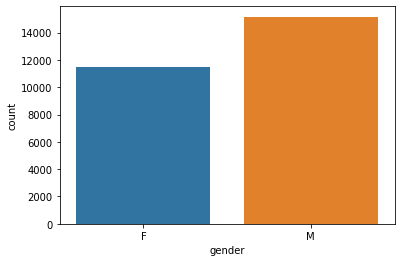

In [ ]:
sns.countplot(attrib['gender']);

##### view-position

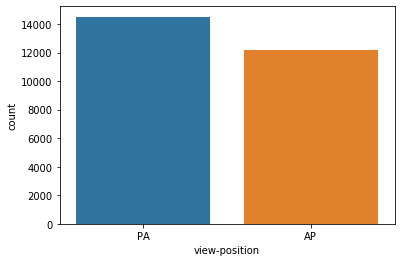

In [ ]:
sns.countplot(attrib['view-position']);

#### Plotting CXR images

In [ ]:
def plot_image(filename):
    'Display x-ray image with bounding boxes (if applicable) correspondin to filename'
    
    # reading dicom file
    file = dicom.dcmread(images_path / filename)
    
    # id is just 'filename' with it's extension(dcm) having removed
    id = filename.split('.')[0]  
    
    # All records corresponding to a particular id
    # Each record contains Target-variable value (1/0) and box-position information
    records = labels[labels['patientId']==id]
    
    fig, ax = plt.subplots(1)
    
    # Whether this patient (this id) is pneumonic or not
    if (len(records)==1 and records['Target'].values[0]==0):
        has_pneumonia = False
    else:
        has_pneumonia = True

    # If pneumonic then draw the bbox as well else only plot the image
    if has_pneumonia:
        # Iterating over all the records to get bbox
        for i, s in records.iloc[:, 1:5].iterrows():
            bbox = Rectangle((s['x'], s['y']), s['width'], s['height'], color='blue',
                             fill=False)
            ax.add_patch(bbox)
        ax.imshow(file.pixel_array, cmap='gray')
    else:
        ax.imshow(file.pixel_array, cmap='gray')
    
    # which class (of the total 3 classes) does this id belong to
    c = class_info[class_info['patientId'] == id]['class'].values[0]
    ax.set_xlabel(c)

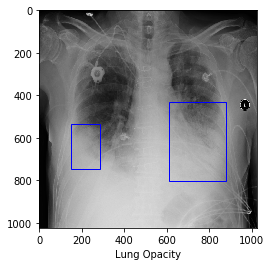

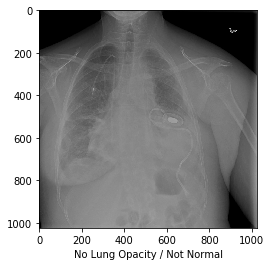

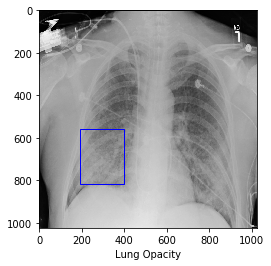

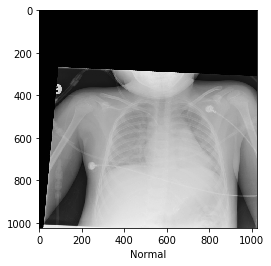

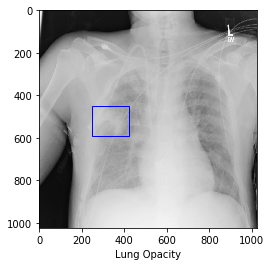

In [ ]:
# ploting 5 random scans
for _ in range(5):
    n = np.random.randint(n_patient)
    filename = os.listdir(images_path)[n]
    plot_image(filename)

- This is a object-detection problem, where the 'object' is potentially-infected-area.
- Convolutional Neural Networks have proved to be very successful in object-detection problems. So we are going to build a model based on CNN
- We are going to employ a technique called Transfer Learning, where a pre-trained model is used as a starting point and fine-tuned with a different dataset.

## Models for solving the Problem

we have employed below three models to get the perfect solution for the Pneumonia Detection Problem
1.	Basic CNN model from scratch with 8 layers 
2.	Residual Neural Network (ResNet) CNN from Scratch with depth of 4
3.	PreDesigned Mask RCNN Model 


# Basic CNN Model from Scratch with 8 Layers

Mounting the device for retriving and saving the data from google drive

In [ ]:
!pip3 install pydicom

     |████████████████████████████████| 35.5MB 90kB/s 


In [ ]:
tf.__version__

'2.3.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/phemonia_capstone_eda/'
os.chdir(path)

Mounted at /content/drive


Using unzip command to retrieve the data from google drive, extract it in colab

In [ ]:
!unzip '/content/drive/My Drive/phemonia_capstone_eda/rsna-pneumonia-detection-challenge.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: /content/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: /content/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: /content/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: /content/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: /content/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: /content/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: /content/stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: /content/stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: /content/stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: /content/stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  i

In [ ]:
path='/content/'
os.chdir(path)

Method to store the patients id who are having pneumonia

In [ ]:
pneumonia_locations = {}
# load table
with open('/content/stage_2_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

### Dividing the data into trian, validation and test set 

In [ ]:

# load and shuffle filenames
folder = '/content/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples


n train samples 24124
n valid samples 2560


"\n\ntrain_filenames = os.listdir('/content/train_data')\nvalid_filenames = os.listdir('/content/test_data')\nn_valid_samples = len(train_filenames)\nn_train_samples = len(valid_filenames)\n"

### Defining the generator class which gives the image and the respective mask of a patient

In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = cv2.resize(img, (self.image_size, self.image_size))
        msk = cv2.resize(msk, (self.image_size, self.image_size)) 
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    

        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        # load files
        items = [self.__load__(filename) for filename in filenames]
        # unzip images and masks
        imgs, msks = zip(*items)
        # create numpy batch
        imgs = np.array(imgs)
        msks = np.array(msks)
        return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

 ### Defining matrices and loss fucntions
 - Matrices
  - Dice coefficient
  - Mean IOU
 <br>

- Loss 
 - img_loss
 - iou and bce loss

In [ ]:
import tensorflow as tf
def dice_coefficient(y_true, y_pred):
    numr = 2 * tf.reduce_sum(y_true*y_pred)
    denom = tf.reduce_sum(y_pred + y_true) 
    return numr/(denom + tf.keras.backend.epsilon())



from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def img_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

### Defining the model

The Basic model which was built from scratch includes combination of 2D convolution layers, Maxpooling layers and Conv2dTranspose layers, having final depth of 8 such combinations. The model uses relu as activation function, having 3x3 srtides , takes 256x256 sized image and uses Adam optimiser while compiling.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,LeakyReLU,UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [ ]:
def model(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

Defining the cosine annealing function for learning rate

In [ ]:
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.00001
    epochs = 50
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
    
reduced_lr = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#reduced_lr = ReduceLROnPlateau( monitor= 'val_accuracy',patience= 2, verbose= 1, factoar= 0.3, min_lr= 0.000001)

Using generator function to generate train and valid datas as required by the model

In [ ]:
folder = '/content/stage_2_train_images'
folder_train = '/content/train_data'
folder_test = '/content/test_data'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True )
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True)

In [ ]:
tf.config.run_functions_eagerly(True)

Compiling the model with adam optimizer

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss=img_loss,metrics=[dice_coefficient, 'binary_accuracy',mean_iou])

### Training the model

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[reduced_lr], epochs=50, shuffle=True,workers=10)

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
753/753 [==============================] - 338s 449ms/step - loss: 2.2350 - dice_coefficient: 0.1890 - binary_accuracy: 0.9299 - mean_iou: 0.1516 - val_loss: 1.4122 - val_dice_coefficient: 0.3046 - val_binary_accuracy: 0.9569 - val_mean_iou: 0.3354
Epoch 2/50
753/753 [==============================] - 339s 451ms/step - loss: 1.4788 - dice_coefficient: 0.2919 - binary_accuracy: 0.9555 - mean_iou: 0.3671 - val_loss: 1.2938 - val_dice_coefficient: 0.3333 - val_binary_accuracy: 0.9582 - val_mean_iou: 0.4147
Epoch 3/50
753/753 [==============================] - 339s 450ms/step - loss: 1.3751 - dice_coefficient: 0.3190 - binary_accuracy: 0.9583 - mean_iou: 0.4560 - val_loss: 1.3868 - val_dice_coefficient: 0.3294 - val_binary_accuracy: 0.9708 - val_mean_iou: 0.5567
Epoch 4/50
753/753 [==============================] - 340s 451ms/step - loss: 1.3037 - dice_coefficient: 0.3419 - binary_accuracy: 0.9612 - mean_iou: 0.5005 - val_loss: 1.4225 - val_dice_coefficient: 0.3133 - val_binary_

Libraries used for visualization

In [ ]:
from skimage import measure
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

Predicting the bounding box

In [ ]:
keys = pneumonia_locations.keys()
list1= list()
pn_file = list()
for i in keys:
  list1.append(i)
len(list1)

for i in range(32):
  pn_file.append(list1[i] + '.dcm')
  print(pn_file)


lt=os.listdir(path+'/stage_2_train_images')
i=0
for fily in lt:
  #pn_file= i
  pn_file.append(fily)
  print(pn_file)
  i+=1
  if(i>=32):
    break


testing_gen = generator(folder, pn_file, pneumonia_locations, batch_size=32, image_size=256, shuffle=True )


['00436515-870c-4b36-a041-de91049b9ab4.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '00aecb01-a116-45a2-956c-08d2fa55433f.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '00aecb01-a116-45a2-956c-08d2fa55433f.dcm', '00c0b293-48e7-4e16-ac76-9269ba535a62.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '00aecb01-a116-45a2-956c-08d2fa55433f.dcm', '00c0b293-48e7-4e16-ac76-9269ba535a62.dcm', '00f08de1-517e-4652-a04f-d1dc9ee48593.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '00aecb01-a116-45a2-956c-08d2fa55433f.dcm', '00c0b293-48e7-4e16-ac76-9269ba535a62.dcm', '00f08de1-517e-4652-a04f-d1dc9ee48593.dcm', '0100515c-5204-4f31-98e0-f35e4b00004a.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


(72, 56, 173, 123)
(91, 70, 93, 71)
(92, 68, 93, 69)
(94, 69, 95, 70)
(95, 48, 96, 49)
(96, 53, 97, 54)
(97, 47, 114, 56)
(99, 63, 100, 64)
(103, 63, 104, 64)
(106, 54, 107, 55)
(108, 54, 110, 55)
(109, 56, 110, 57)
(111, 56, 113, 57)
(115, 51, 116, 52)
(154, 198, 155, 199)
(154, 188, 188, 215)
(122, 51, 177, 108)
(124, 85, 128, 91)
(126, 82, 127, 84)
(128, 73, 129, 74)
(128, 79, 129, 80)
(128, 83, 129, 86)
(130, 74, 131, 76)
(163, 181, 181, 203)
(175, 202, 176, 203)
(126, 172, 174, 213)
(59, 143, 191, 206)
(76, 37, 174, 96)
(113, 79, 175, 119)
(115, 110, 116, 111)
(117, 161, 182, 201)
(141, 118, 142, 119)
(106, 163, 169, 202)
(48, 31, 202, 100)
(59, 160, 60, 162)
(60, 48, 175, 111)
(60, 165, 62, 167)
(62, 159, 65, 161)
(64, 105, 65, 106)
(64, 162, 66, 164)
(66, 157, 69, 160)
(66, 167, 67, 168)
(67, 161, 69, 164)
(67, 170, 71, 176)
(68, 109, 69, 110)
(68, 166, 71, 169)
(68, 175, 69, 176)
(69, 177, 71, 180)
(70, 182, 72, 184)
(71, 158, 73, 164)
(72, 160, 83, 173)
(72, 148, 196, 213)
(73

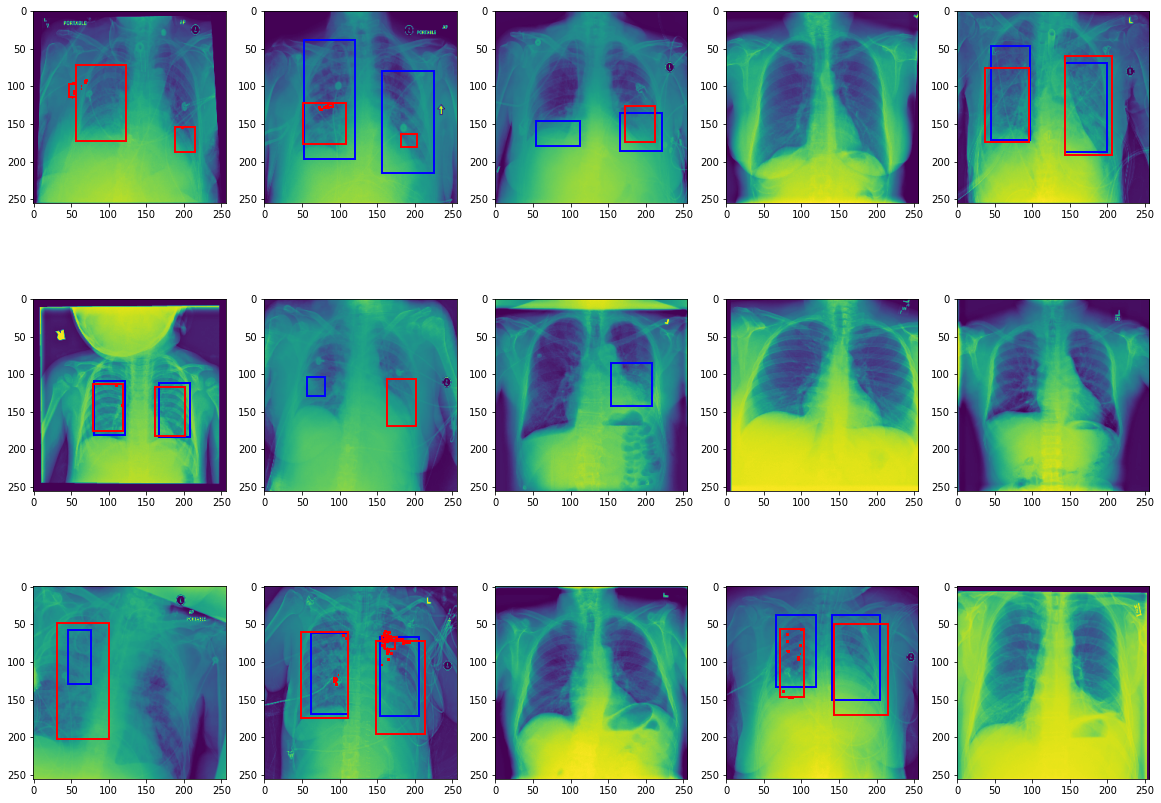

In [ ]:

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for imgs, masks in testing_gen:
    # Predict a batch of images
    predictions = model.predict(imgs)
    # Create a plot for the images
    fig, axes = plt.subplots(3, 5, figsize=(20, 15))
    axes = axes.ravel()
    axidx = 0
    
    # Loop through the batch
    for img, mask, prediction in zip(imgs, masks, predictions):
        axes[axidx].imshow(img[:,:,0])
        
        # Apply threshold to true mask
        comp = mask[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none'))
            
        # Apply threshold to the predicted mask
        comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        predTarget = 0
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            # If a region is found mark the target value as 1
            predTarget = 1
            print(region.bbox)
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))
        
        #axes[axidx].text(0.05, 0.95, f'Actual target: \nPredicted target: {predTarget}', transform=axes[axidx].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        axidx += 1
        if(axidx >= 15):
            break;
        
    plt.show()
    
    # Display only one plot per batch
    break


##### In the above cell we can see predicted boxes with red colour and ground truth with blue boxes. ( if not able to see the images, please scroll down to the end :) )

Variation of loss and mean_iou for training and validation data.


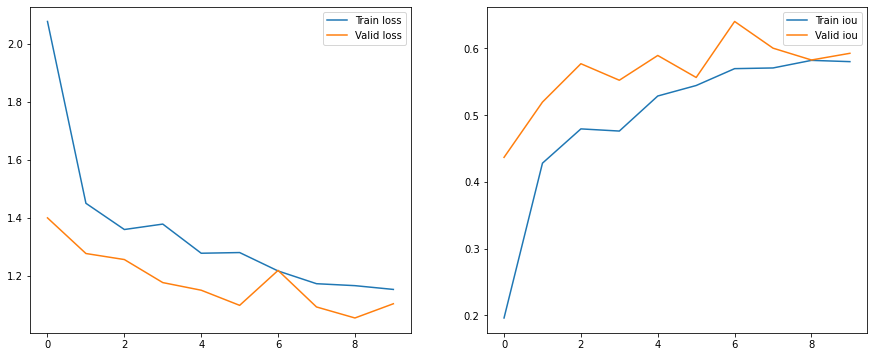

In [ ]:
print('Variation of loss and mean_iou for training and validation data.')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

Saving the model in drive

In [ ]:
config = model.get_config()
model.from_config(config)

In [ ]:
path='/content/drive/My Drive/phemonia_capstone_eda/saved_model_2'
os.chdir(path)

In [ ]:
model.save(path)

Function to load the model from drive

In [ ]:
def f1(y_true, y_pred):
    return 1
n_model= tf.keras.models.load_model('/content/drive/My Drive/phemonia_capstone_eda/saved_model_2',custom_objects={'f1':f1})
n_model

##### with this CNN Model we could able to get mean_iou accuracy  mean_iou: 65.86%

##### that paved the way for more exploration and tried with ResNet

# Residual Neural Network (ResNet) CNN from Scratch with depth of 4

In [ ]:
import pandas as pd
import numpy as np
import pydicom
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2
from concurrent.futures import ProcessPoolExecutor
from skimage import measure
import keras
import random


In [ ]:
PROJECT_PATH = "/content/drive/My Drive/ColabNotebooks/capstone/"
root_dir=PROJECT_PATH+'dataUpload/data/'

In [ ]:
trainDataDir = 'stage_2_train_images'
testDataDir = 'stage_2_test_images'

trainDicomFiles = {}
testDicomFiles = {}


with tf.device('/device:GPU:0'):
  for root, dirs, files in os.walk(os.path.join(root_dir, trainDataDir)):
      for fileName in files:
          if '.dcm' in fileName.lower():
              trainDicomFiles[fileName.split(sep='.')[0]] = os.path.join(root_dir, trainDataDir, fileName)     
        

In [ ]:
len(trainDicomFiles)

26684

In [ ]:
trainLabelDetailedDf = pd.read_csv(root_dir+'stage_2_train_labels.csv')

class_info_df = pd.read_csv(root_dir+'/stage_2_detailed_class_info.csv') 

In [ ]:
print('trainLabelDetailedDf.shape',trainLabelDetailedDf.shape)

print('class_info_df.shape',class_info_df.shape)

trainLabelDetailedDf.shape (30227, 6)
class_info_df.shape (30227, 2)


Though The train_labels_df and class_info_df datasets do not share a joining keyword column, but if the rows are listed in the exact same order , therefore we can combine the two dataframes by concatenating their columns.

In [ ]:
assert trainLabelDetailedDf['patientId'].values.tolist() == class_info_df['patientId'].values.tolist(), 'PatientId columns are different.'
train_labels_df = pd.concat([trainLabelDetailedDf, class_info_df.drop(labels=['patientId'], axis=1)], axis=1)

In [ ]:
train_labels_df.head(5)

patientId  ...                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity

[5 rows x 7 columns]

In [ ]:
uniquePatientIds = np.unique(train_labels_df.patientId)
trainLabelAndBoundingBoxDf = pd.DataFrame(columns=['patientId', 'target', 'class', 'boundingBox', 'num_of_opacities']
                                          , index=uniquePatientIds)


In [ ]:
patientIdBasedGroups = train_labels_df.groupby('patientId')

In [ ]:
#with tf.device('/device:GPU:0'):

for patientId, group in patientIdBasedGroups:
#     if counter > 20:
#         break
    trainLabelAndBoundingBoxDf.loc[patientId]['patientId'] = patientId
    trainLabelAndBoundingBoxDf.loc[patientId]['num_of_opacities'] = 0
    boundingBox = []
    for index, groupItem in group.iterrows():
        trainLabelAndBoundingBoxDf.loc[patientId]['target'] = groupItem['Target']
        trainLabelAndBoundingBoxDf.loc[patientId]['class'] = groupItem['class']
        
        if(not np.isnan(groupItem['x'])):
            boundingBox.append((groupItem['x'], groupItem['y'], groupItem['width'], groupItem['height']))
            trainLabelAndBoundingBoxDf.loc[patientId]['num_of_opacities'] += 1
            
    trainLabelAndBoundingBoxDf.loc[patientId]['boundingBox'] = boundingBox


In [ ]:

class ImageDataGenerator(keras.utils.Sequence):
    def __init__(self, patientIds, batch_size=32,augment=True, dim=(1024,1024), shuffle=True):
        self.patientIds = patientIds
        self.batch_size = batch_size
        self.dim=dim
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    def __load__(self, patientId):
        # Load the dicom file as a numpy array
        dicom_image = pydicom.dcmread(trainDicomFiles[patientId]).pixel_array

        # Create an empty mask to hold the list of bounding boxes as image segments.
        bounding_box_mask = np.zeros(dicom_image.shape) 

        # Generate the mask using the label data frame
        targetLabelDf = trainLabelAndBoundingBoxDf.loc[patientId]
        if targetLabelDf['target'] == 1:
            for box in targetLabelDf['boundingBox']:
                x, y, width, height = [int(item) for item in box]
                bounding_box_mask[y:y+height, x:x+width] = 1

        # Resizing the image for reduction (to help build faster model).
        dicom_image = cv2.resize(dicom_image, (self.dim[0], self.dim[1]))
        bounding_box_mask = cv2.resize(bounding_box_mask, (self.dim[0], self.dim[1]))
        if self.augment and random.random() > 0.5:
            dicom_image = np.fliplr(dicom_image)
            bounding_box_mask = np.fliplr(bounding_box_mask)
        dicom_image = np.expand_dims(dicom_image, -1)
        bounding_box_mask = np.expand_dims(bounding_box_mask, -1)
        target = targetLabelDf['target']
        return dicom_image, bounding_box_mask, target

    def __len__(self):
        # Represents the number of batches per epoch
        return int(len(self.patientIds) / self.batch_size)
    
    def __getitem__(self, index):
        # Generates the indexes associated with one batch
        targetPatientIds = self.patientIds[index * self.batch_size : (index + 1) * self.batch_size]
        
        items = [self.__load__(id) for id in targetPatientIds]

        # Zip the images and masks for the target patients.
        imgs, masks, targets = zip(*items)

        # Create numpy batch
        imgs = np.array(imgs)
        masks = np.array(masks)
        targets = np.array(targets)
        return imgs, masks, targets
        
    def on_epoch_end(self):
        # Shuffles the data after every epoch
        if self.shuffle:
            np.random.shuffle(self.patientIds)

Lets create the convolutional neural network using resnet blocks.\
The model consists of a
* Downsampling block (consisting of Batch normalization, leaky ReLU, Convolutional 2D and max pool layer) \
* ResNet block (consisting of batch normalization, leaky ReLU and convolutional 2D layers). \

The downsampling and resnet blocks are repeated based on configuration parameters of n_blocks and depth. \

In the end we upsample the data points to the same size as before in order to get the target mask.

In [ ]:

def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    #x = keras.layers.Dropout(0.3)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # Input
    inputs = keras.Input(shape=(input_size, input_size, 1))

    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # Residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
    # Output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:

def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

print('Combine BCE and IOU loss')
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)
  

print('Get mean IOU as a metric')
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis = [1, 2, 3])
    union = tf.reduce_sum(y_true, axis = [1, 2, 3]) + tf.reduce_sum(y_pred, axis = [1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

Combine BCE and IOU loss
Get mean IOU as a metric


In [ ]:
print('Generating the network instance.')
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])

epoch_count = 10

model.summary()

Generating the network instance.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________

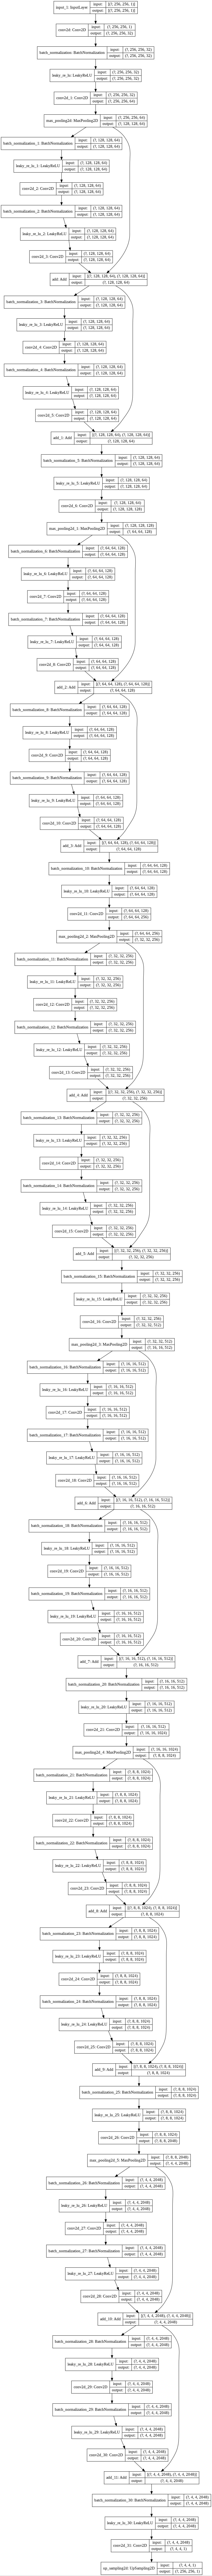

In [ ]:
dot_img_file = root_dir+'/model_depth6_epoch10.jpeg'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
print('Training the model.')
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

training_data_percent = 0.8
training_data_end_index = int(trainLabelAndBoundingBoxDf.shape[0] * training_data_percent)
training_patientIds_box = trainLabelAndBoundingBoxDf['patientId'][0:training_data_end_index]
validation_patientIds_box = trainLabelAndBoundingBoxDf['patientId'][training_data_end_index:]

params = {'dim': (512, 512), 'batch_size': 32, 'shuffle': True}
training_data_generator_box = ImageDataGenerator(training_patientIds_box, **params)
validation_data_generator_box = ImageDataGenerator(validation_patientIds_box, **params)



Training the model.


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(training_data_generator_box, validation_data=validation_data_generator_box, callbacks=[learning_rate], epochs=epoch_count, workers=4)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
583/583 [==============================] - 3494s 6s/step - loss: 0.1603 - accuracy: 0.9484 - mean_iou: 0.6498 - val_loss: 0.1111 - val_accuracy: 0.9813 - val_mean_iou: 0.8243
Epoch 2/10
583/583 [==============================] - 712s 1s/step - loss: 0.1557 - accuracy: 0.9546 - mean_iou: 0.6720 - val_loss: 0.1096 - val_accuracy: 0.9394 - val_mean_iou: 0.5410
Epoch 3/10
583/583 [==============================] - 712s 1s/step - loss: 0.1522 - accuracy: 0.9503 - mean_iou: 0.6684 - val_loss: 0.1074 - val_accuracy: 0.9678 - val_mean_iou: 0.7574
Epoch 4/10
583/583 [==============================] - 712s 1s/step - loss: 0.1469 - accuracy: 0.9549 - mean_iou: 0.6790 - val_loss: 0.1052 - val_accuracy: 0.9653 - val_mean_iou: 0.7387
Epoch 5/10
583/583 [==============================] - 714s 1s/step - loss: 0.1435 - accuracy: 0.9564 - mean_iou: 0.6865 - val_loss: 0.1014 - val_accuracy: 0.9674 - val_mean_iou: 0.7458
Epoch 6/10
583/583 [==============================] - 713s 1s/step - loss:

##### mean IOU accuracy of is 72.81% with ResNet Model, let us also examine how the loss and mean_iou trend for each epoc

Below is the representation of variation of loss and mean_iou for training and validation data.


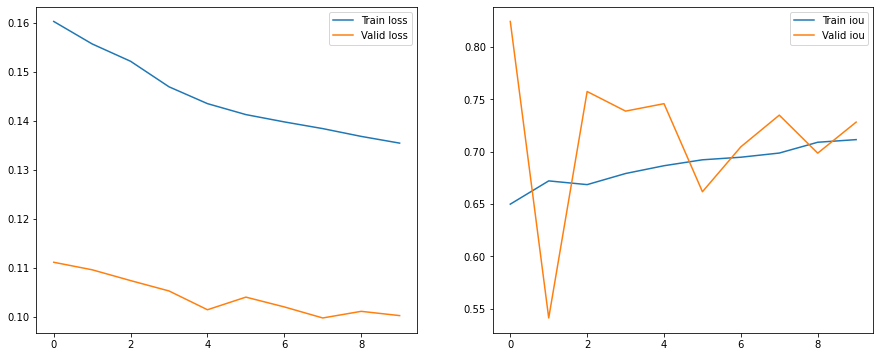

In [ ]:
print('Below is the representation of variation of loss and mean_iou for training and validation data.')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

Let's do the the predictions for the validation data set to get the confustion matrix and visualize how the bounding boxes as predicted.

In [ ]:
y_pred = []
y_true = []


In [ ]:
print('We can generate the y_pred and y_true arrays to hold the target values (predicted and actual) for all the validation \
data points.')
with tf.device('/device:GPU:0'):
  for imgs, masks, targets in validation_data_generator_box:
      predictions = model.predict(imgs)
      
      # Loop through the predictions along with the actual targets
      for img, mask, prediction, target in zip(imgs, masks, predictions, targets):
          # Apply threshold to the predicted mask
          comp = prediction[:,:,0] > 0.5
          
          # Apply connected components.
          comp = measure.label(comp)
          
          # Take the initial prediction as 0
          predTarget = 0
          
          # Apply bounding boxes
          for region in measure.regionprops(comp):
              # If a region is found mark the target value as 1
              predTarget = 1
              
          y_pred.append(predTarget)
          y_true.append(target)
              

We can generate the y_pred and y_true arrays to hold the target values (predicted and actual) for all the validation data points.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
def printConfusionMatrix(title, y_true, y_pred):
    print (title)
    print ('-------------------')
    print ('Validation Accuracy: ', accuracy_score(y_true,y_pred))
    print ('Validation Precision: ', precision_score(y_true,y_pred))
    print ('Validation Recall: ', recall_score(y_true,y_pred))
    print ('Validation F1-Score: ', f1_score(y_true,y_pred))
    
    cm=confusion_matrix(y_true, y_pred, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict Yes","Predict No"]])
    #Plot the heat map for the confusion matrix
    plt.figure(figsize = (5,5))   
    sns.heatmap(df_cm, annot=True, fmt="g", yticklabels=["Actual Yes", "Actual No"], cmap="YlGnBu_r")
    ax = plt.gca()
    ax.set_title(title)    
    plt.show()

ResNet Model
-------------------
Validation Accuracy:  0.810875
Validation Precision:  0.47326732673267324
Validation Recall:  0.6804270462633452
Validation F1-Score:  0.5582481751824818


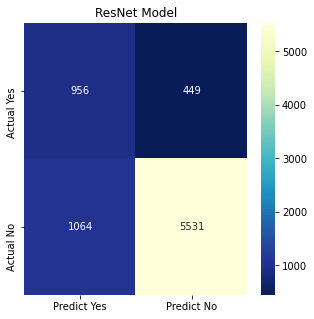

In [ ]:
printConfusionMatrix("ResNet Model", y_true, y_pred)

In [ ]:
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

We can now analyze the predictions on the validation data.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


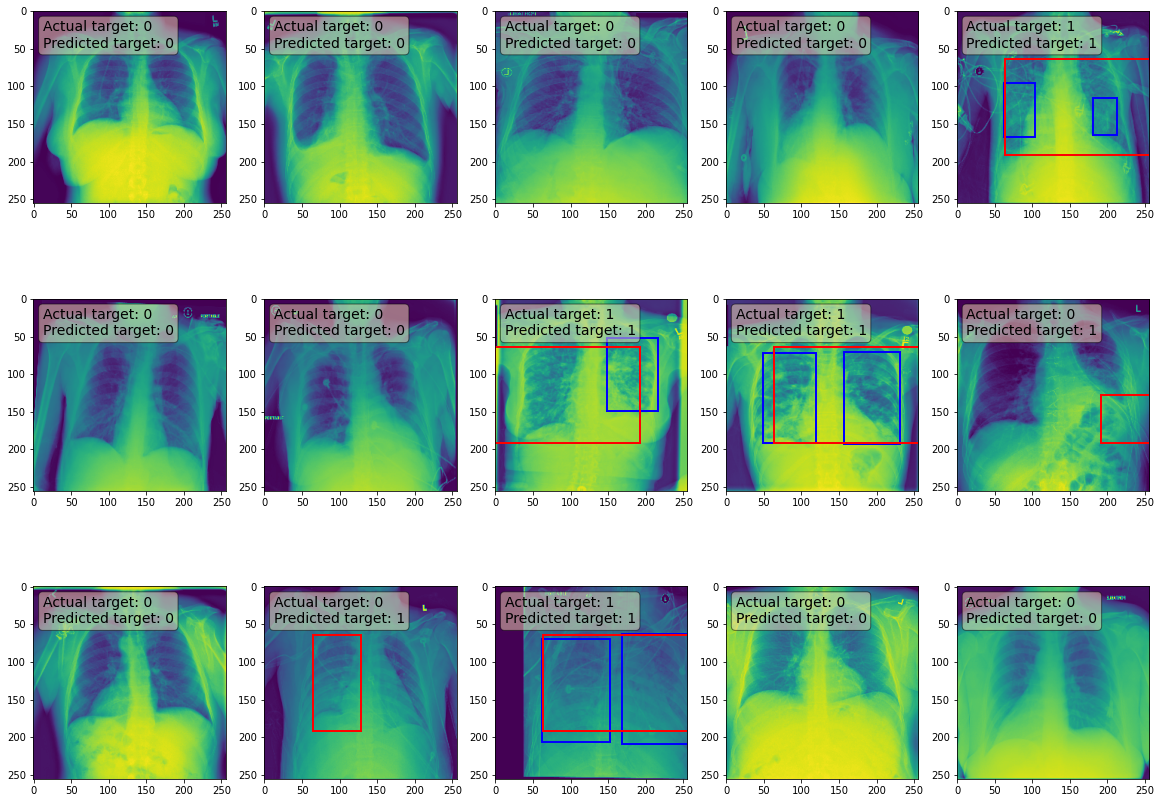

In [ ]:
print('We can now analyze the predictions on the validation data.')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for imgs, masks, targets in validation_data_generator_box:
    # Predict a batch of images
    predictions = model.predict(imgs)
    # Create a plot for the images
    fig, axes = plt.subplots(3, 5, figsize=(20, 15))
    axes = axes.ravel()
    axidx = 0
    
    # Loop through the batch
    for img, mask, prediction, target in zip(imgs, masks, predictions, targets):
        axes[axidx].imshow(img[:,:,0])
        
        # Apply threshold to true mask
        comp = mask[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none'))
            
        # Apply threshold to the predicted mask
        comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        predTarget = 0
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            # If a region is found mark the target value as 1
            predTarget = 1
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))
        
        axes[axidx].text(0.05, 0.95, f'Actual target: {target} \nPredicted target: {predTarget}', transform=axes[axidx].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        axidx += 1
        if(axidx >= 15):
            break;
        
    plt.show()
    
    # Display only one plot per batch
    break


#####  predicted boxes with red colour and ground truth with blue boxes. we can obeserve that though the not giving the exact region correctly but it is nearest to the ground truth



considering the mean_iou accuracy of 72.81%, Validation Accuracy:  0.810875 and Validation Recall:  0.6804270462633452

It isn't a perfect model to rely on so we explored the PreDesigned MaskRCNN Model

## Mask RCNN Model

#### Following files are going to be used in the creation of this model:
- **stage_2_train_images_jpeg_512_only_1.rar** - rar-file contains images, resized to dimensions-512x512, belonging to class-1
- **stage_2_train_images_jpeg_512.zip** - - zip-file contains all images (both classes), resized to dimensions-512x512
- **labels_new** - Labels data is in the same format as the original one but the values have been modified corresponding to images with dimensions, 512x512


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extracting all Images belonging to class-1
# uncomment if not so
!pip install unrar
!unrar x '/content/drive/My Drive/pneumonia_detection/stage_2_train_images_jpeg_512_only_1.rar' -d /content

Streaming output truncated to the last 5000 lines.
Extracting  /content/stage_2_train_images_jpeg_512_only_1/3251dea8-4f74-4f4b-8f56-167b0213414b.jpeg      16%  OK 
Extracting  /content/stage_2_train_images_jpeg_512_only_1/3258ba2b-f4fe-45f2-ac47-5d6d1fa5819c.jpeg      16%  OK 
Extracting  /content/stage_2_train_images_jpeg_512_only_1/32652bc7-21e2-4aa4-ae0c-461950e4c131.jpeg      16%  OK 
Extracting  /content/stage_2_train_images_jpeg_512_only_1/32659f33-5e60-4db1-9696-657e54b769c8.jpeg      16%  OK 
Extracting  /content/stage_2_train_images_jpeg_512_only_1/32721abb-10c7-4797-88c6-bf47d32e95e6.jpeg      16%  OK 
Extracting  /content/stage_2_train_images_jpeg_512_only_1/327573f4-41c7-471b-b613-50dbb86a02da.jpeg      16%  OK 
Extracting  /content/stage_2_train_images_jpeg_512_only_1/3275fe4e-18e7-4fe2-94f9-aa0d725232aa.jpeg      17%  OK 
Extracting  /content/stage_2_train_images_jpeg_512_only_1/32764f2f-ea89-4d7c-aa7d-e70366

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# The MaskRCNN library that we will be using requires specific versions of some packages
# Installing packages
!pip install tensorflow-gpu==1.15.3
!pip install Keras==2.2.4
!pip install pydicom
!pip install wget

     |████████████████████████████████| 411.0MB 41kB/s 
     |████████████████████████████████| 3.8MB 47.0MB/s 
     |████████████████████████████████| 512kB 39.0MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=85d150dacfd407367e71708fa008fd9815b5710a877b307e8da28413df885f97
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

In [ ]:
!ls

drive  sample_data  stage_2_train_images_jpeg_512_only_1


In [ ]:
cd /content/drive/My Drive/pneumonia_detection

/content/drive/My Drive/pneumonia_detection


In [ ]:
# Clonning MaskRCNN library from github
import os
if 'Mask_RCNN' not in os.listdir():
  !git clone https://github.com/matterport/Mask_RCNN.git  

In [ ]:
!ls

id_to_intId  Mask_RCNN		  rsna-pneumonia-detection-challenge
labels_new   mask_rcnn_coco.h5	  saved
logs	     nb.ipynb		  stage_2_train_images_jpeg_512_only_1
logs2	     pneumonia.ipynb	  stage_2_train_images_jpeg_512_only_1.rar
logs_old     pneumonia_old.ipynb  stage_2_train_images_jpeg_512.zip


In [ ]:
cd Mask_RCNN

/content/drive/My Drive/pneumonia_detection/Mask_RCNN


In [ ]:
# installing MaskRCNN API
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/__init__.py to __init_

In [ ]:
# importing packages
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2 as cv
import pydicom as dicom

from mrcnn.visualize import display_instances
from mrcnn.utils import Dataset
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.config import Config 
from mrcnn.model import MaskRCNN 
from mrcnn.model import mold_image 
from mrcnn.model import load_image_gt
from mrcnn.visualize import display_instances

Using TensorFlow backend.


In [ ]:
cd ..

/content/drive/My Drive/pneumonia_detection


In [ ]:
# path of data folder
data_path = Path('rsna-pneumonia-detection-challenge')

### Labels data

In [ ]:
!ls

id_to_intId  Mask_RCNN		  rsna-pneumonia-detection-challenge
labels_new   mask_rcnn_coco.h5	  saved
logs	     nb.ipynb		  stage_2_train_images_jpeg_512_only_1
logs2	     pneumonia.ipynb	  stage_2_train_images_jpeg_512_only_1.rar
logs_old     pneumonia_old.ipynb  stage_2_train_images_jpeg_512.zip


In [ ]:
filename = 'labels_new'
if filename not in os.listdir():
  print(f'{filename} not found in {Path.cwd()}')
else:
  import pickle
  with open(filename, 'rb') as infile:
    labels_new = pickle.load(infile)

In [ ]:
labels_new.shape

(30227, 6)

In [ ]:
labels_new.head(5)

patientId    x    y  width height Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  NaN  NaN    NaN    NaN      0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  NaN  NaN    NaN    NaN      0
2  00322d4d-1c29-4943-afc9-b6754be640eb  NaN  NaN    NaN    NaN      0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  NaN  NaN    NaN    NaN      0
4  00436515-870c-4b36-a041-de91049b9ab4  132   76  106.5  189.5      1

#### id_to_intId: dict, mapping of each patient's id to a unique integer id¶

In [ ]:
# generating an integer id for each patient, saving it so as to use same mapping in the future
if 'id_to_intId' not in os.listdir():
  id_to_intId = {id: i for i, id in enumerate(labels_new['patientId'].unique())}
  filename = 'id_to_intId'
  with open(filename, 'wb') as outfile:
    pickle.dump(id_to_intId, outfile)
else:
  filename = 'id_to_intId'
  with open(filename, 'rb') as infile:
    id_to_intId = pickle.load(infile)

In [ ]:
# definning image dimensions
IMAGE_WIDTH, IMAGE_HEIGHT = 512, 512

##### Note: Train and test data only contains images from class 1 as this is the approach that we are going to employ for the prediction of boundung-box coordinates.
##### Later when performing final evaluation, we will append class-0 images as well in the original proportion

In [ ]:
# class for preparation and loading of train and test data
class PneumoniaDataset(Dataset):
    def load_dataset(self, dataset_dir, train_size=0.8, for_train=True):
        # define one class
        self.add_class('dataset', 1, 'pneumonia')
        # define data location (jpeg)

        # class-1 images
        images_path1 = Path('/content/stage_2_train_images_jpeg_512_only_1')
        images = np.asarray(os.listdir(str(images_path1)))
        n_images = len(images)
        
        # spliting data into train and test
        if for_train:
            train_filter = np.remainder(np.arange(n_images), int(train_size*10)) != 0
            images = images[train_filter]
        elif not for_train:
            test_filter = np.remainder(np.arange(n_images), int(train_size*10)) == 0
            images = images[test_filter]

        # extract bounding-box-position
        for image_name in images:
            id = image_name.split('.')[0]
            label = labels_new[labels_new['patientId'] == id].iloc[:, 1:]
            bboxes = []
            for _, bbox in label.iterrows():
                bboxes.append(bbox)
            image_id = id_to_intId[id]
            
            image_path = images_path1 / image_name
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=image_path, bboxes=bboxes)

        
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # get box-position
        bboxes = info['bboxes']
        # create one array for all masks, each on a different channel
        masks = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, len(bboxes)], dtype='uint8')
        # create masks
        class_ids = []
        for i, bbox in enumerate(bboxes): 
            if  bbox['Target'] == 0:
                class_ids.append(self.class_names.index('pneumonia'))
                break
            # float to int
            bbox = bbox.astype(int)
            row_s, row_e = bbox['x'], bbox['x'] + bbox['width']
            col_s, col_e = bbox['y'], bbox['y'] + bbox['height']
            masks[col_s: col_e, row_s:row_e, i] = 1
            class_ids.append(self.class_names.index('pneumonia'))
        return (masks, np.asarray(class_ids, dtype='int32'))
    
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [ ]:
# train set
train_set = PneumoniaDataset()
train_set.load_dataset(data_path, train_size=0.8, for_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test set
test_set = PneumoniaDataset()
test_set.load_dataset(data_path, train_size=0.8, for_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 5260
Test: 752


If you encounter the below error, re-run the cell until no error - 
#### OSError: [Errno 5] Input/output error: 'rsna-pneumonia-detection-challenge/stage_2_train_images'

### Training dataset

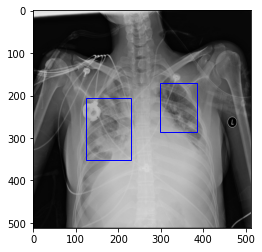

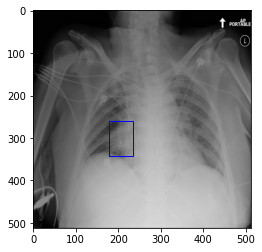

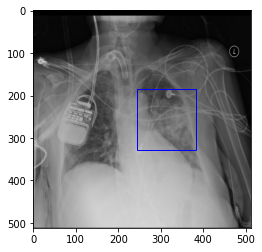

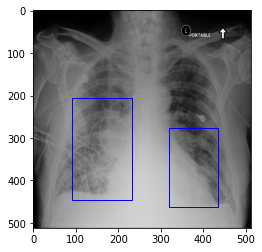

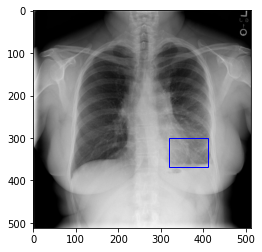

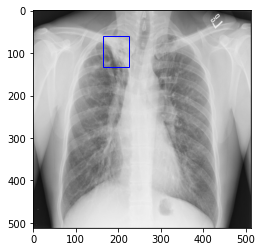

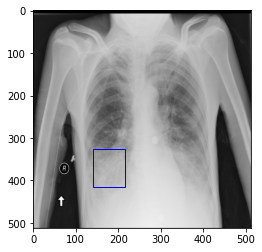

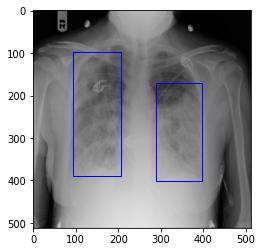

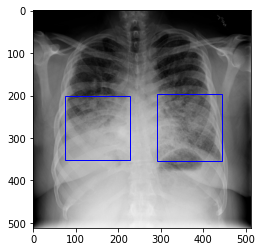

In [ ]:
# plot first few images
for i in range(9):
    # define subplot
    fig, ax = plt.subplots(1)
#     plt.figure(figsize=(12, 12))
#     plt.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
#     plt.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    bboxes = extract_bboxes(mask)
    for bbox in bboxes:
        if np.sum(bbox) == 0:
            break
        y, x, y_, x_ = bbox 
        h, w = y_ - y, x_ - x
        patch = Rectangle((x, y), w, h, color='blue', fill=False)
        ax.add_patch(patch)
    ax.imshow(image)

# show the figure
plt.show()

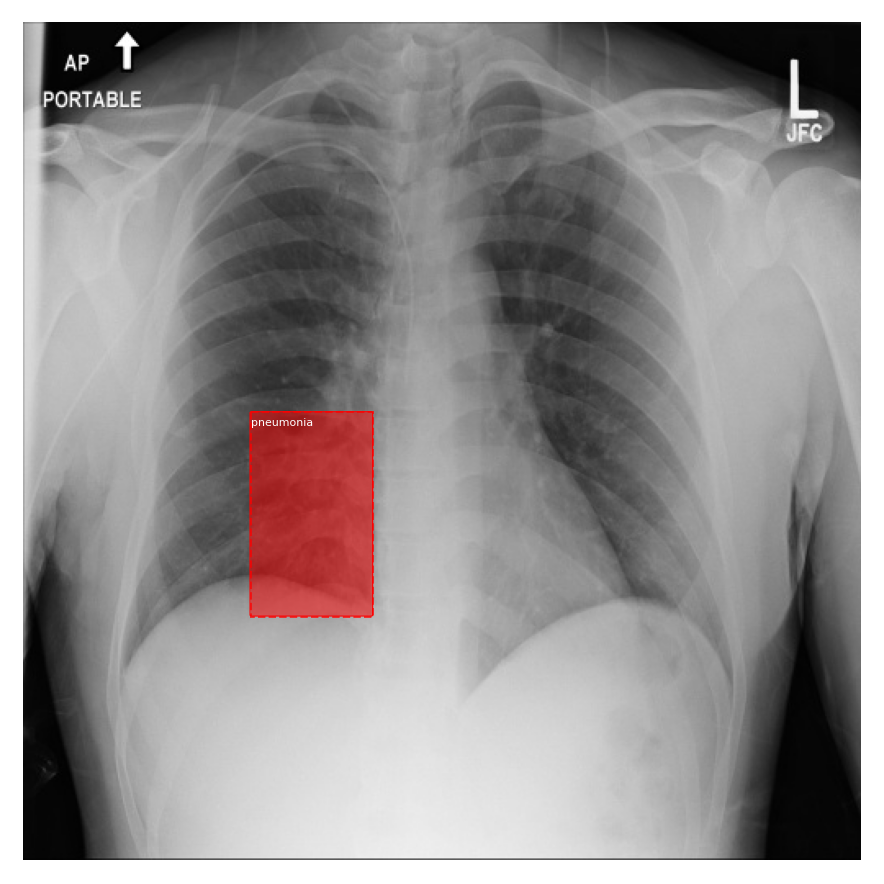

In [ ]:
image_id = 42
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

### Trainning approach
There are several ways to train MaskRCNN - 
- One is to train only the 'head' layers, which is whats called Tranfer Learning wherein we start with pre-trained weights and train only top layers (higer-level). We tried that and found that `loss` would start converging without learning enough, this is perhaps because the pre-trained model is trained on real-life, data-to-day object's images which are vastly different from the images we have here which are X-ray images.

- We can also include more layers to train.
- However, since these images belongs to a vastly different category, we decided to not to use pre-pretrained model and train all the layers.

##### Below is the whole trainning process

#### We require to create a model-configuration file, which defines various parameters and settings like, Learning-rate, epoch-size, etc.

#### calculating mean-value of images which is one of the model's configuration

In [ ]:
# means = np.empty(shape=len(train_set.image_ids), dtype='uint8')
# for i, image_id in enumerate(train_set.image_ids):
#   # load the image
#   image = train_set.load_image(image_id)
#   mean = image.mean()
#   means[i] = mean

# MEAN = means.mean()
# print(MEAN)

#### mean-value turns out to be 124.57

In [ ]:
# define a configuration of the model
class PneumoniaConfig(Config):
    # Give the configuration a recognizable name
    NAME = 'pneumonia_cfg'
    # Number of class (background + pneumonia)
    NUM_CLASSES = 1 + 1        

    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 8

    # Number of training steps per epochs
    STEPS_PER_EPOCH = 1000 // IMAGES_PER_GPU

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 80 // IMAGES_PER_GPU

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # Image mean (RGB)
    MEAN_PIXEL = np.array([124.57, 124.57, 124.57])  

    IMAGE_RESIZE_MODE = 'square'
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    IMAGE_CHANNEL_COUNT = 3


    BACKBONE = 'resnet50'

    TRAIN_ROIS_PER_IMAGE = 128

    MAX_GT_INSTANCES = 50
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.8

    DETECTION_NMS_THRESHOLD = 0.01

    LEARNING_RATE = 0.001

    # Loss weights for more precise optimization.
    # Can be used for R-CNN training setup.
    # setting 'mrcnn_mask_loss' to 0 as this is irrelevant to our task
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 0.
    }
    

# prepare config
config = PneumoniaConfig()

#### Confiuration: 
- `IMAGES_PER_GPU` should be as high as possible. We had access to atmost 12 GB of GPU RAM which allowed us to set it to atmost 8.
- The role of Backbone is to extract features which coukd then furher be passed to CNN-layers. Two options are available here: 'resnet50' and 'resnet101', the latter one being a relatively deep network. We set `BACKBONE` to 'resnet50' to reuce memory load and for faster trainning.
- `DETECTION_NMS_THRESHOLD`:It may so happen that the model predicts overlapping bounding-boxes, rendering some predictions to be useless. This is exactly what we noticed in some initial results. We changed it's value from 0.3 (default) to 0.01 after epoch-80.
- `TRAIN_ROIS_PER_IMAGE` - We set it to 128. It may be lowered down to increase trainning speed with the expense of performance.
- `LEARNING_RATE`- It had been set to 0.001 throughout the trainning as there had been no plateauing of loss. It might need to be lowered down if trained further.
- Images have been rescaled to 512x512 dimensions to increase trainning speed

In [ ]:
# Directory to save logs and trained model
if 'logs' not in os.listdir():
  os.mkdir('logs')
MODEL_DIR = str(Path.cwd() / 'logs')

In [ ]:
# define the model
model = MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [ ]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
# Load saved model
model_path = '/content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_0260.h5'
model.load_weights(model_path, by_name=True)

Re-starting from epoch 260


### Training

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=20, layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=40, layers='all')


Starting at epoch 20. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=60, layers='all')


Starting at epoch 40. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=80, layers='all')


Starting at epoch 60. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=100, layers='all')


Starting at epoch 80. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=120, layers='all')


Starting at epoch 100. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

Starting from epoch 116

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=130, layers='all')


Starting at epoch 116. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=150, layers='all')


Starting at epoch 130. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=180, layers='all')


Starting at epoch 180. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=200, layers='all')


Starting at epoch 180. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

Epoch 182/200
125/125 [==============================] - 242s 2s/step - loss: 0.5688 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1754 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.3132 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 0.7648 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.3591 - val_mrcnn_class_loss: 0.0803 - val_mrcnn_bbox_loss: 0.3178 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 183/200
125/125 [==============================] - 242s 2s/step - loss: 0.5496 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1620 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 0.7752 - val_rpn_class_loss: 0.0061 - val_rpn_bbox_loss: 0.3208 - val_mrcnn_class_loss: 0.0942 - val_mrcnn_bbox_loss: 0.3541 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 184/200
125/125 [==============================] - 242s 2s/step - loss: 0.5798 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.3131 - mrcnn_mask_loss: 0.0000e+00 - val_l

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=220, layers='all')


Starting at epoch 200. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=240, layers='all')


Starting at epoch 220. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=260, layers='all')


Starting at epoch 240. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

## Inference

Plot graphs

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir {'logs'}

#### Since the model was trained only on class 1 i.e. infected patients and the original data comprise of both class 1 and class 0 (not-infected). Let us now append class 0 to both train_set and test_set maintaining the proportion of classes which in this case is 0.8 for trainset and 0.2 for test_set

##### extracting images class-1 and class-0 to colab's disk

In [ ]:
# Extracting all Images, both classes
# uncomment if not so
!unzip '/content/drive/My Drive/pneumonia_detection/stage_2_train_images_jpeg_512.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/stage_2_train_images_jpeg_512/83208148-1cad-4186-a6c9-97cd0901722a.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/c5bf2e86-f262-4010-8321-466dac552baa.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/7184cc40-a58a-40df-9aa7-39d610190410.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/44334be1-1a2c-4ef3-b1f1-d262ed5f68dc.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/23e9b940-daea-4092-a2c5-6c92bb615e25.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/c5a27c73-aef3-407e-9724-333e97a583c9.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/e6e39bc5-31f7-4315-a9f0-18a86d339c5f.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/f655a822-225d-4fe0-a69f-0886f91c5f2b.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/7cec580b-d147-4f31-8e2b-41ffe8c940c7.jpeg  
  inflating: /content/stage_2_train_images_jpeg_512/c2bf72e6-cedf-423b-9a25-f60e60f67

In [ ]:
# Directory to save logs and trained model
if 'logs' not in os.listdir():
  os.mkdir('logs')
MODEL_DIR = str(Path.cwd() / 'logs')

In [ ]:
class PneumoniaDataset(Dataset):
    def load_dataset(self, dataset_dir, train_size=0.8, for_train=True):
        # define one class
        self.add_class('dataset', 1, 'pneumonia')
        # define data location (jpeg)

        # class-1 images
        images_path1 = Path('/content/stage_2_train_images_jpeg_512_only_1')
        images = np.asarray(os.listdir(str(images_path1)))
        n_images = len(images)
        
        # spliting data into train and test
        if for_train:
            train_filter = np.remainder(np.arange(n_images), int(train_size*10)) != 0
            images = images[train_filter]
        elif not for_train:
            test_filter = np.remainder(np.arange(n_images), int(train_size*10)) == 0
            images = images[test_filter]

        # extract bounding-box-position
        for image_name in images:
            id = image_name.split('.')[0]
            label = labels_new[labels_new['patientId'] == id].iloc[:, 1:]
            bboxes = []
            for _, bbox in label.iterrows():
                bboxes.append(bbox)
            image_id = id_to_intId[id]
            
            image_path = images_path1 / image_name
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=image_path, bboxes=bboxes)

        # class-0 images
        images_path = Path('/content/stage_2_train_images_jpeg_512')
        images = np.asarray(os.listdir(str(images_path)))
        n_images = len(images)
        
        # spliting data into train and test
        if for_train:
            train_filter = np.remainder(np.arange(n_images), int(train_size*10)) != 0
            images = images[train_filter]
        elif not for_train:
            test_filter = np.remainder(np.arange(n_images), int(train_size*10)) == 0
            images = images[test_filter]

        # extract bounding-box-position
        for image_name in images:
            id = image_name.split('.')[0]
            label = labels_new[labels_new['patientId'] == id].iloc[:, 1:]
            bboxes = []
            for _, bbox in label.iterrows():
                bboxes.append(bbox)
            if len(bboxes) == 0:
              continue
            image_id = id_to_intId[id]
            
            image_path = images_path / image_name
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=image_path, bboxes=bboxes)
                  
        
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # get box-position
        bboxes = info['bboxes']
        # create one array for all masks, each on a different channel
        masks = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, len(bboxes)], dtype='uint8')
        # create masks
        class_ids = []
        for i, bbox in enumerate(bboxes): 
            if  bbox['Target'] == 0:
                class_ids.append(self.class_names.index('pneumonia'))
                break
            # float to int
            bbox = bbox.astype(int)
            row_s, row_e = bbox['x'], bbox['x'] + bbox['width']
            col_s, col_e = bbox['y'], bbox['y'] + bbox['height']
            masks[col_s: col_e, row_s:row_e, i] = 1
            class_ids.append(self.class_names.index('pneumonia'))
        return (masks, np.asarray(class_ids, dtype='int32'))
    
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [ ]:
train_set = PneumoniaDataset()
train_set.load_dataset(data_path, train_size=0.8, for_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test set
test_set = PneumoniaDataset()
test_set.load_dataset(data_path, train_size=0.8, for_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 28608
Test: 4088


In [ ]:
# define the prediction configuration
class InferenceConfig(Config):
	# define the name of the configuration
	NAME = "pneumoniua_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1

	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	
	# Length of square anchor side in pixels
	RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

	# Image mean (RGB)
	MEAN_PIXEL = np.array([124.57, 124.57, 124.57])  

	IMAGE_RESIZE_MODE = 'square'
	IMAGE_MIN_DIM = 512
	IMAGE_MAX_DIM = 512

	BACKBONE = 'resnet50'

	TRAIN_ROIS_PER_IMAGE = 128

	# Minimum probability value to accept a detected instance
	# ROIs below this threshold are skipped
	DETECTION_MIN_CONFIDENCE = 0.8

	DETECTION_NMS_THRESHOLD = 0.01

	MAX_GT_INSTANCES = 50

In [ ]:
# create config
cfg = InferenceConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=cfg)

In [ ]:
# Load saved model
model_path = '/content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200930T1618/mask_rcnn_pneumonia_cfg_0260.h5'
model.load_weights(model_path, by_name=True)

Re-starting from epoch 260


In [ ]:
def evaluate_model(dataset, model, cfg):
  TP = 0
  TN = 0
  FP = 0
  FN = 0
  APs = []
  image_ids = dataset.image_ids
  for image_id in image_ids:
    # load image, bounding boxes and masks for the image id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    # convert pixel values (subtract MEAN_PIXEL)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = np.expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)
    # extract results for first sample
    r = yhat[0]
    # calculate statistics include AP
    AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5)
    # store
    if np.isnan(AP):
      APs.append(0)
      continue
    APs.append(AP)

    # calculating TP, TN, FP, FN
    if len(r['rois']) != 0:
      if len(gt_bbox) != 0:
        TP += 1
      else:
        FP += 1
    else:
      if len(gt_bbox) != 0:
        FN += 1
      else:
        FP += 1
  mAP = np.mean(APs)
  return mAP, TP, TN, FP, FN

###### MAP at epoch 191

In [ ]:
# evaluate model on test set
test_mAP, TP, TN, FP, FN = evaluate_model(test_set, model, cfg)
print('Test mAP: %.3f' % test_mAP)

Test mAP: 0.101


### MAP at epoch 260

In [ ]:
# epoch 260
# evaluate model on training set
# train_mAP = evaluate_model(train_set, model, cfg)
# print('Train mAP: %.3f' % train_mAP)
# evaluate model on test set
test_mAP, TP, TN, FP, FN = evaluate_model(test_set, model, cfg)
print('Test mAP: %.3f' % test_mAP)

Test mAP: 0.121


### Classification accuacy

##### at epoch 191

In [ ]:
# at epoch 191
print('Precision: ', TP/(TP + FP))
print('Recall: ', TP/(TP + FN))

Precision:  0.6193181818181818
Recall:  0.8229238160603981


### at epoch 260

In [ ]:
# epoch 260
print('Precision: ', TP/(TP + FP))
print('Recall: ', TP/(TP + FN))

Precision:  0.8480243161094225
Recall:  0.9574468085106383


In [ ]:
# at epoch 260
print(TP, TN, FP, FN)

1395 0 250 62


## Visualize predictions on the held-out data (**test-set**)

##### Actual (**class-1**) vs Predicted


*** No instances to display *** 


*** No instances to display *** 



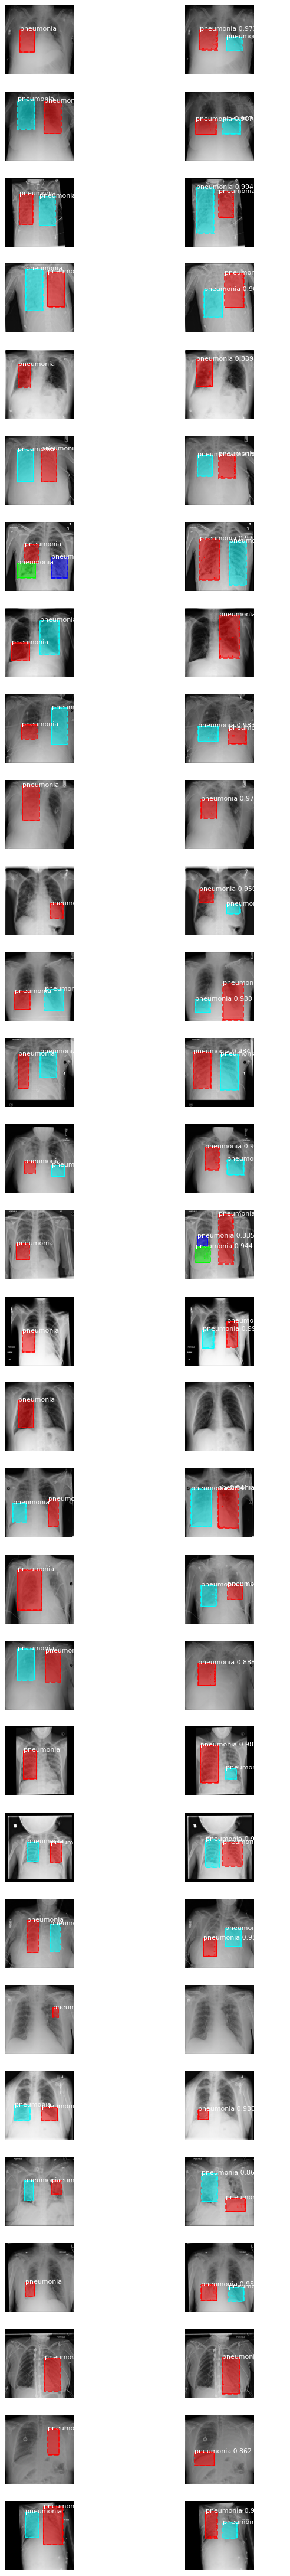

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = test_set
fig, ax = plt.subplots(30, 2, figsize=(10, 80))

j = 0
while j != 30:
  image_id = np.random.choice(dataset.image_ids)
  # image_id = 100 * i
  image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
  if gt_bbox.shape[0] == 0:
    continue
  display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset.class_names, ax=ax[j][0])
  scaled_image = mold_image(image, cfg)
  results = model.detect([scaled_image]) #, verbose=1)
  r = results[0]
  display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax[j][1])
  j += 1

##### Actual (**class-0**) vs Predicted


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to

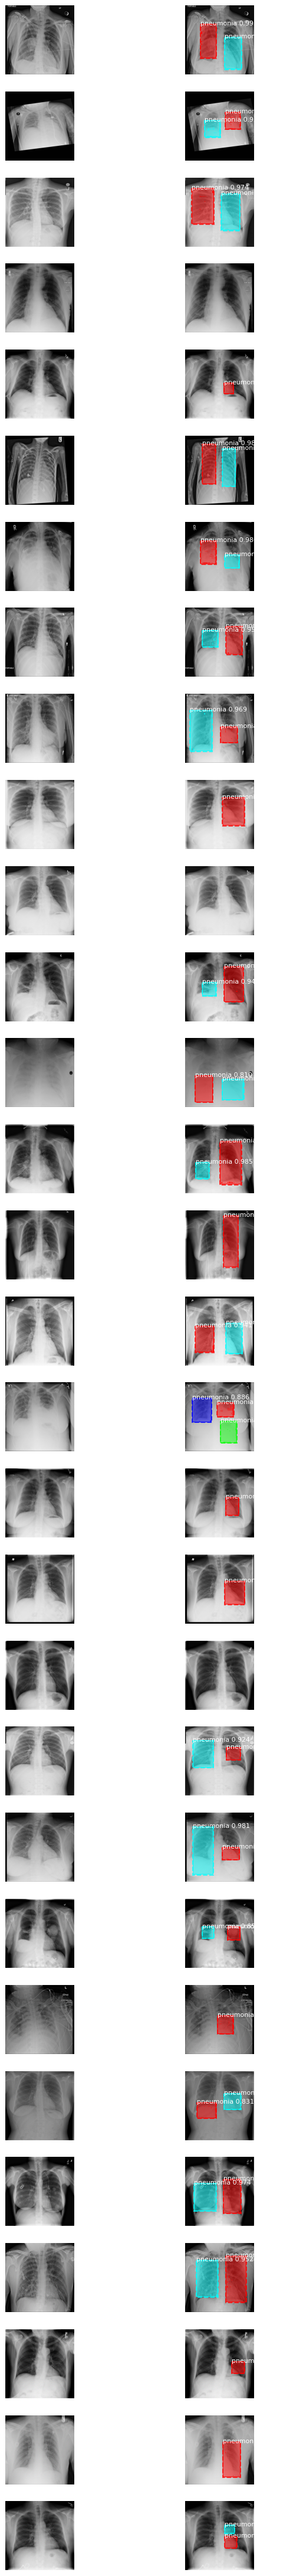

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = test_set
fig, ax = plt.subplots(30, 2, figsize=(10, 80))

j = 0
while j != 30:
  image_id = np.random.choice(dataset.image_ids)
  # image_id = 100 * i
  image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
  if gt_bbox.shape[0] != 0:
    continue
  display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset.class_names, ax=ax[j][0])
  scaled_image = mold_image(image, cfg)
  results = model.detect([scaled_image]) #, verbose=1)
  r = results[0]
  display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax[j][1])
  j += 1

In [ ]:
image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(train_set, cfg, 40, use_mini_mask=False)
scaled_image = mold_image(image, cfg)
sample = np.expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)
r = yhat[0]
# len(gt_bbox)
# overlap(gt_bbox, r['rois'])
# Ap, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5)
# print(Ap)

### The evaluation metric uesd is MAP (Mean Average Precision), maximum can be 1 and minimum be 0 
### We have gotten an MAP of 0.12. To put that into percpective, the best model listed on kaggle has gotten an MAP of 0.25.

## Limitations
#### As can be seen the model performed fairly-well in predicting bbox in case if the patient is infected but performed badly in case of non-infected patients.
#### Putting in other way, there are many of false-positives

### To improve upon this
- one may employ some data augmentation techniques and train  for more epochs.
- another way could be to train a classifier, which is presumably not a very hard problem, to first classify an image into class-1 or class-0 and then predict bounding box only if it belongs to class 1. This way many false positive would be eliminated at the classifier model.

## Comparision of Models that we tried 

## Conclusion and Final Remarks